In [191]:
using PyPlot;

In [224]:
include("src/utils.jl");

# Problem 19.1 #

Consider the problem of finding the point on a curve closest to (1,1,1). Specifically, the optimization problem 

\begin{align*}
\text{minimize }&\quad (x_1-1)^2 +(x_2-1)^2 +(x_3-1)^2\\
\text{subject to }&\quad x_1^2+0.5x_2^2+x_3^2-1 = 0\\
&\quad 0.8x_1^2+2.5x_2^2+x_3^2+2x_1x_3-x_1-x_2-x_3-1 = 0
\end{align*}

Equivalently the problem can be written as 

$$
\begin{align*}
    \text{minimize }&\quad f(x)\\
    \text{subject to }&\quad g(x) = 0
\end{align*}
$$
where $f : \mathbf{R} \rightarrow \mathbf{R}$ and $g : \mathbf{R}^3 \rightarrow \mathbf{R}^2$. The Jacobians are given by 

$$
\begin{align*}
    Df = \begin{bmatrix}
        2(x_1-1) & 2(x_2-1) & 2(x_3-1)
    \end{bmatrix}\quad
    Dg = \begin{bmatrix}
        2x_1 & x_2 & 2x_3\\
        1.6x_1+2x_3-1 & 5x_2-1 & 3x_3+2x_1-1
    \end{bmatrix}
\end{align*}
$$

In [207]:
function f(x::Vector{T}) where T <: Real
    return sum((x - vec(ones(3))).^2)
end

function f_jacobian(x::Vector{T}) where T <: Real
    return 2 * (x - 1)';
end

function g(x::Vector{T}) where T <: Real
    squared_input = x.^2;
    g1 = sum(squared_input .* (vec([1 0.5 1]))) - 1;
    g2 = sum(squared_input .* vec([0.8 2.5 1])) + 2 * x[1] * x[3] - sum(x) - 1;
    
    return vcat(g1,g2);
end

function g_jacobian(x::Vector{T}) where T <: Real
    g1_deriv = vec([2 1 2]) .* x;
    g2_deriv = vec([1.6 5 3]) .* x + vec([2*x[3] 0 2*x[1]]) - 1;
    
    return hcat(g1_deriv, g2_deriv)'
end

g_jacobian (generic function with 1 method)

In [226]:
srand(791074);
xtraj_p, mu_p, cume_iters_p = penalty_algo((3,1,2), f, f_jacobian, g, g_jacobian; xinit=vec(zeros(3)), max_iters=100);
xtraj_al, mu_al, cume_iters_al = augmented_lagrangian((3,1,2), f, f_jacobian, g, g_jacobian; xinit=vec(zeros(3)), max_iters=100);

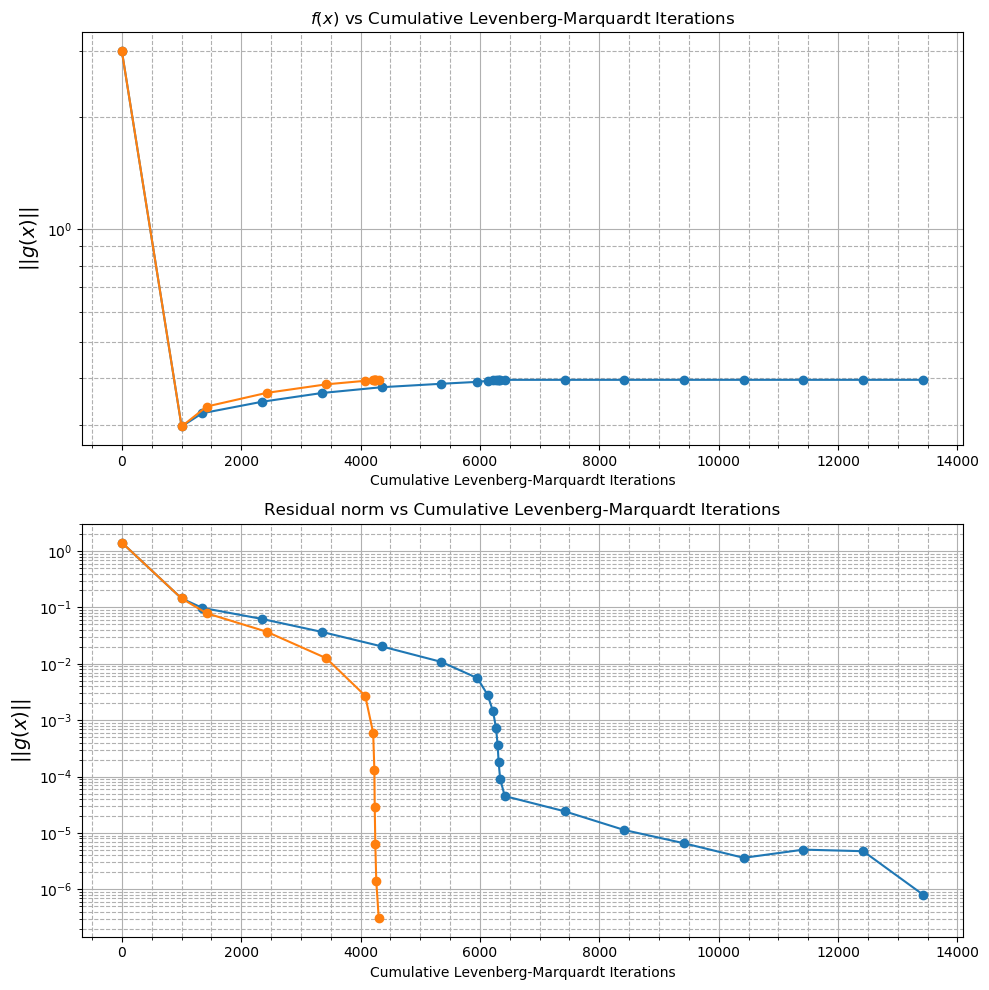

In [230]:
figure(figsize=(10,10));

subplot(211);
objective_p = [norm(f(xtraj_p[:,i])) for i=1:size(xtraj_p,2)];
objective_al = [norm(f(xtraj_al[:,i])) for i=1:size(xtraj_al,2)];

semilogy(cume_iters_p', objective_p, marker="o");
semilogy(cume_iters_al', objective_al, marker="o");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
ylabel(L"$||g(x)||$", fontsize=14);
xlabel("Cumulative Levenberg-Marquardt Iterations");
title(L"$f(x)$ vs Cumulative Levenberg-Marquardt Iterations");
PyPlot.minorticks_on();

subplot(212);
equality_residual_p = [norm(g(xtraj_p[:,i])) for i=1:size(xtraj_p,2)];
equality_residual_al = [norm(g(xtraj_al[:,i])) for i=1:size(xtraj_al,2)];

semilogy(cume_iters_p', equality_residual_p, marker="o");
semilogy(cume_iters_al', equality_residual_al, marker="o");

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on()

ylabel(L"$||g(x)||$", fontsize=14);
xlabel("Cumulative Levenberg-Marquardt Iterations");
title("Residual norm vs Cumulative Levenberg-Marquardt Iterations");

PyPlot.tight_layout();

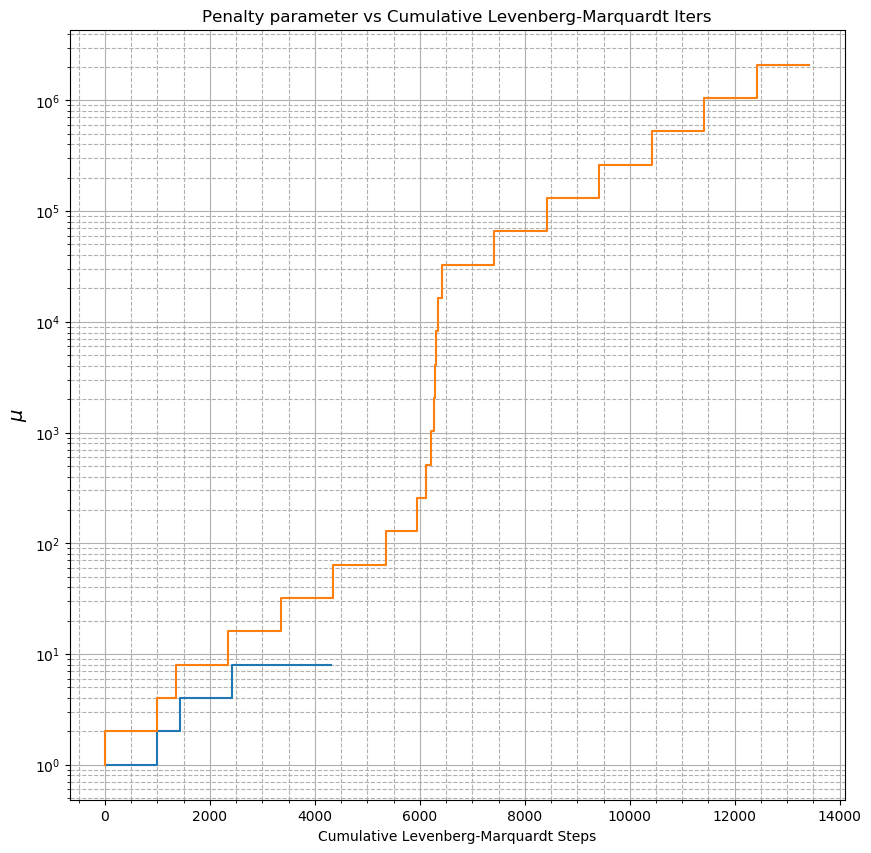

In [256]:
figure(figsize=(10,10))

semilogy(1.0, 1.0,"w");
step(cume_iters_al[:], mu_al[:]);
step(cume_iters_p[:], mu_p[:]);

title("Penalty parameter vs Cumulative Levenberg-Marquardt Iters");
xlabel("Cumulative Levenberg-Marquardt Steps");
ylabel(L"$\mu$", fontsize=14);

grid(true, which="major");
grid(true, which="minor",linestyle="--");
PyPlot.minorticks_on()

# Problem 19.2 #

The downside-risk portfolio optimization problem is given by 

\begin{align*}
    \text{minimize}_{\omega}\quad& \frac{1}{T} \Sigma_{t=1}^T \left(\max\left\{\rho^{\text{tar}} - r_t^T\omega, 0\right\}\right)^2\\
    \text{subject to}\quad& \begin{bmatrix}
    \mathbf{1}^T\\
    \mu^T
    \end{bmatrix}\omega = \begin{bmatrix}
    1 \\
    \rho^{\text{tar}} 
    \end{bmatrix}
\end{align*}

where $r_t^T$ is the $t$'th row of $R\in \mathbf{R}^{T\times n}$ and $n$ is the number of assets

This is a constrained non-linear least squares problem with $f_i(\omega) = \max\left\{\rho^{\text{tar}} - r_i^T\omega, 0\right\}$ and $g(\omega) = [\mathbf{1},\ \mu]^T \omega - [1,\ \rho^{\text{tar}}]^T$. The Jacobians are 

\begin{align*}
    Df(\omega) = \begin{bmatrix}
          -r_1^T\mathbf{1}(\rho^{\text{tar}} - r_1^T\omega > 0)\\
          -r_2^T\mathbf{1}(\rho^{\text{tar}} - r_2^T\omega > 0)\\
          \vdots \\
          -r_T^T\mathbf{1}(\rho^{\text{tar}} - r_T^T\omega > 0)\\
    \end{bmatrix}\quad
    Dg(\omega) = \begin{bmatrix}
                \mathbf{1}^T\\
                \mu^T         
    \end{bmatrix}
\end{align*}